In [200]:
import numpy as np
import sys
import math
import itertools
import matplotlib.pyplot as plt  
import networkx as nx
from pqdict import pqdict

# Árbol Generador Mínimo

## 7.1 Introducción

Los algoritmos de Árbol Generador Mínimo (AGM) tienen como entrada un grafo pesado conexo y devuelven un subgrafo con todos los nodos y una subselección de los ejes cuya suma es la mínima posible. Esto implica que el subgrafo resultante sea un árbol, ya que no habrá ejes superfluos que formen ciclos.

Veremos 2 algoritmos _greedy_ que obtienen este árbol: **Kruskal** y **Prim**, que sólo difieren en el método utilizado para determinar que ejes deben ser incluídos en el AGM. Paso a paso irán agregando 1 eje al árbol hasta incluir todos los nodos del grafo original. Lo que estos algoritmos deben resolver es determinar que ejes son _safe_ para agregar al árbol. 

Un eje _safe_ es un eje que no rompe la propiedad constante en el _loop_ de estos algoritmos: a cada paso, el árbol que se va construyendo es un subgrafo del AGM. Es decir, los ejes que se agregan no se quitan, por lo que todo eje agregado debe ser uno de los ejes del AGM.

Cabe aclarar que si bien nos referimos a un AGM, éste puede no ser único y haber más de un AGM para 1 sólo grafo. Por ejemplo, es posible que para un mismo grafo, Kruskal y Prim devuelvan AGM distintos. Lo seguro es que la suma de los pesos de los ejes de ambos AGMs será idéntica, la mínima.

<img src="agm_1.png" alt="mm" style="width: 1200px;"/>

En la primer imagen se resaltan los ejes que pertenecen al AGM, cuya suma es 37, la mínima posible. En la segunda se ve un paso intermedio arbitrario en donde los vértices resaltados en negro ya pertenecen al recorte **S**. Los ejes resaltados fuera del corte son los ejes que pertenecerán al AGM y el eje `(c, d)` es denominado _light_ , por cruzar la frontera del corte ya resuelto (subgrafo del AGM), y este eje será _safe_ para agregar al árbol creciente. Notar también que el eje `(b, c)` será incluído en el AGM en lugar del `(a, h)`, y esto no es una necesidad. Existe un AGM alternativo donde este escenario se invierte.

Creemos un grafo como el de la figura para probar nuestros algoritmos:

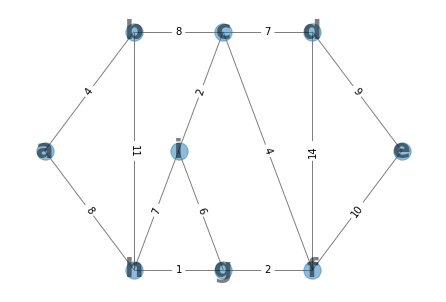

In [104]:
G = nx.Graph()
G.add_weighted_edges_from([("a", "b", 4), ("a", "h", 8), ("b", "h", 11), ("b", "c", 8), ("c", "i", 2), ("i", "h", 7), ("h", "g", 1),
("i", "g", 6), ("c", "f", 4), ("c", "d", 7), ("d", "f", 14), ("d", "e", 9), ("e", "f", 10), ("f", "g", 2) ])

pos = nx.spring_layout(G, seed=20)
pos["a"] = [-1, 0]
pos["b"] = [-.5, 1]
pos["c"] = [0, 1]
pos["d"] = [.5, 1]
pos["e"] = [1, 0]
pos["f"] = [.5, -1]
pos["g"] = [0, -1]
pos["h"] = [-.5, -1]
pos["i"] = [-.25, 0]

labels = nx.get_edge_attributes(G, 'weight')
nx.draw(G, pos, with_labels = True, alpha = .5, font_size = 26, font_weight = 'bold')
plt = nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)

--------

## 7.2 Kruskal

En términos conceptuales, el algoritmo de Kruskal crea un árbol de cada nodo (es decir, un bosque), y luego va uniendo estos nodos con los ejes de menor peso hasta terminar con un único árbol. Utilizando los ejes en orden creciente se asegura que el árbol resultante sea mínimo y cuidando que cada eje agregado no contenga nodos de un mismo árbol se asegura que no haya ciclos y el resultado sea efectivamente un árbol.

En realidad, el bosque inicial es una estructura de datos llamada _disjoint set_ o _union find_. La utilizaremos para saber que nodos ya fueron unidos en un mismo árbol sin tener que explorar todo el bosque.

In [100]:
def agm_kruskal(G):
    A = nx.Graph()
    bosque = nx.utils.UnionFind()

    ejes = G.edges(data = True)
    ejes = sorted(ejes, key = lambda t: t[-1].get("weight", 1))

    for u, v, att in ejes:
        if bosque[u] != bosque[v]:
            A.add_weighted_edges_from([(u, v, att["weight"])])
            bosque.union(u, v)
    return A


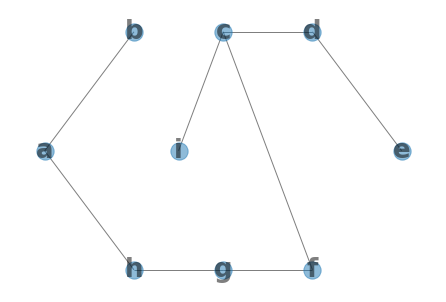

In [103]:
agm = agm_kruskal(G)
nx.draw(agm, pos, with_labels = True, alpha = .5, font_size = 26, font_weight = 'bold')

Notamos que Kruskal incluyó el eje `(a, h)` en vez del `(b, c)`. Como ya dijimos, ambos árboles son AGMs.

## Complejidad

Ordenar los ejes consume $O(m  \log(m))$. Por otro lado, el ciclo principal se ejecuta $m$ veces en las que se hacen búsquedas y uniones en los _disjoint sets_; el costo de estas operaciones será alguna función de $n$, que crecerá más lento que $O(n)$, por lo que asumiremos que es $O(n)$. Así, el costo de este ciclo será de: $O(m  \log(n))$.

Entonces, la complejidad del algoritmo completo sería:

$$
O(m  \log(m)) + O(m  \log(n)) ==> O(m  \log(m))
$$
Que es igual a $O(m  \log(n))$:
$$
O(m  \log(m)) = O(m  \log(n))
$$

ya que sabemos que lidiamos con un grafo conexo. Entonces: $m \leq n^{2}$, por lo tanto:

$$
O(m  \log(m)) ==> O(m  \log(n^{2})) ==> O(2 m  \log(n)) ==> O(m  \log(n))
$$

## 7.3 Prim

A diferencia de Kruskal, Prim empieza con un único árbol al que le va agregando ejes hasta completar el AGM. Prim sigue un camino más intuitivo y similar a al procedimiento general que vimos en la introducción: hay una frontera entre 2 conjuntos de ejes, los que son parte del árbol creciente que se convertirá en el AGM y los ejes restantes del grafo que no han sido evaluados aún. Prim evalúa los ejes que cruzan esta frontera e incorpora (de manera _greedy_), al de menor peso.


In [235]:
def agm_prim(G, inicial):
    A = nx.Graph()
    Q = pqdict()
    predecesores = {}
    for v in G.nodes():
        predecesores[v] = None
        if v == inicial:
            Q[v] = 0
        else:
            Q[v] = np.inf

    while len(Q) != 1:
        u = Q.pop()
        for v in G[u]:
            if v in Q and G[u][v]['weight'] < Q[v]:
                Q[v] = G[u][v]['weight']
                predecesores[v] = u
        v, w = Q.topitem()            
        A.add_weighted_edges_from([(predecesores[v], v, w)])
    
    return A

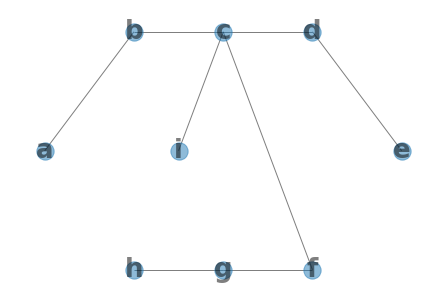

In [236]:
agm = agm_prim(G, 'h')
nx.draw(A, pos, with_labels = True, alpha = .5, font_size = 26, font_weight = 'bold')

Kruskal entrega un AGM como el de la figura inicial. Descarta el eje `(a, h)` por el de `(b, c)`.

## Complejidad

Observando el código podemos encontrar similitudes al algoritmo de BFS ya visto, y también al de Dijsktra que todavía está por verse.

Entre el ciclo `while` principal y el `for` interior se evaluarán todas las adyacencias por lo que se actualizará la cola (en la línea `Q[v] = G[u][v]['weight']`), $m$ veces. Asumiendo que la complejidad de reordenar la cola de prioridad sea de $\log(n)$, la compejidad de Prim será de:

$$
O(m  \log(n))
$$

la misma que Kruskal.

---

## 7.4 Conclusión

* Pueden aprovechar la notebook, correr el código, hacer sus propios grafos, y generar sus nuevos AGMs. Pero sólo hagan esto para profundizar la comprensión del tema. Lo principal es que pasen a la resolución de ejercicios. El código es auxiliar.
* Leer del Cormen: **p(624-638)**

--------------------

### Contenidos a explicar durante la práctica